In [87]:
import numpy as np
import functools as ft
import math
import pickle
import numba
from numba import njit, prange, vectorize
from scipy.special import eval_jacobi, hyp2f1
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [88]:
# Must restrict to massless case due to boundary scaling

d = 4
m = 0
Dpl = d/2 + 0.5 * np.sqrt(d * d + 4.0 * m * m)
Dmin = d/2 - 0.5 * np.sqrt(d * d + 4.0 * m * m)
NPOW = 15
J_0 = 1.
LMAX = 6
DX = np.pi/(2*((2**NPOW) + 1))
XGRID = np.linspace(0, np.pi/2, (2 ** NPOW) + 1, dtype=np.double) # romb method requires 2**k + 1 gridpoints
wbar = 1/4

In [89]:
# See recursion relationships between Jacobi polynomials

@njit(parallel=True)
def my_jacobi(n, a, b, x):
    if n < 0:
        return 0.
    elif n == 0:
        return J_0
    elif n == 1:
        return (a + 1) + (a + b + 2) * (x - 1) / 2
    else:
        jac_factor = 2 * n + a + b - 1
        outval = jac_factor * ((jac_factor + 1) * (jac_factor - 1) * x + (a * a)\
                               - (b * b)) * my_jacobi(n - 1, a, b, x)
        outval -= 2 * (n + a - 1) * (n + b - 1) * (jac_factor + 1) * my_jacobi(n - 2, a, b, x)
        return outval / (2 * n * (n + a + b) * (jac_factor - 1))
                    
my_jacobi(4, d/2 - 1, Dpl - d/2, np.cos(2 * np.pi/3))

-1.2109375000000004

In [ ]:
# Writing hypergeometric functions that utilized the numba package
# has proved to produce functions that are SLOWER than calling
# built-in functions. Below is an example of the attempt to write
# numba-compliant hypergeometric functions.

"""
# Needed in evalutating the hypergeometric functions

@njit(parallel=True)
def my_factorial(n):
    if n < 0:
        return np.inf
    elif n == 0:
        return 1
    else:
        return n * my_factorial(n - 1)
        
# Express hypergeometric function in terms a finite sum

@njit(parallel=True)
def my_2F1(a, b, c, x):
    tol = 1.E-6
    outval = 1.
    k = 1
    while(True):
        next_term = math.gamma(a + k) * math.gamma(b + k) * math.gamma(0.5 * a + 0.5 * b) * x ** k /\
            (math.gamma(a) * math.gamma(b) * math.gamma(0.5 * a + 0.5 * b + k) * my_factorial(k))
        # Failsafe
        if (k > 1E5):
            print("\nERROR: no convergence in my_2F1\n")
            break
        # When the next term is a less than the specified
        # relative tolerance, return the value
        elif (abs(next_term / outval) < tol):
            break
        # Otherwise, add to the output value, increment and repeat
        else:
            outval += next_term
            k += 1
    return outval

my_2F1((Dpl+wbar)/2, (Dpl-wbar)/2, d/2, np.sin(np.pi/4) ** 2)
    
my_factorial(3)

%timeit my_2F1((Dpl+wbar)/2, (Dpl-wbar)/2, d/2, np.sin(np.pi/4) ** 2)
9.64 µs ± 77.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
"""

In [ ]:
%timeit hyp2f1((Dpl+wbar)/2, (Dpl-wbar)/2, d/2, np.sin(np.pi/4) ** 2)

In [90]:
@njit(parallel=True)
def mu(x):
    return (np.tan(x)) ** (d-1)

# Evaluate the derivatives analytically
@njit(parallel=True)
def nu(x):
    return (np.cos(x)) ** 2 * (np.tan(x)) ** (2 - d)

@njit(parallel=True)
def nup(x):
    return (1 - d + np.cos(2.*x)) * (np.tan(x)) ** (1 - d) 

@njit(parallel=True)
def omega(i):
    return Dpl + 2 * i
mu(0)
nu(np.pi)
nup(np.pi/4)
omega(0)

4.0

In [91]:
@njit(parallel=True)
def K(i):
    return 2. * np.sqrt((i + Dpl / 2) * math.gamma(i + 1) * math.gamma(Dpl + i) / (math.gamma(i + d/2) * math.gamma(
        i + Dpl + 1 - d/2)))

K(1)

4.898979485566356

In [92]:
# Since basis functions will be called with either integer arguments (normalizable) or
# non-integer arguments (non-normalizable), write one basis function that returns
# either of these types based on the integer nature of the argument

def e(x, i):
    # If integer is passed, return normalizable solution
    if (i % 1 == 0):
        return K(i) * (np.cos(x)) ** Dpl * my_jacobi(i, d/2 - 1, Dpl - d/2, np.cos(2 * x))
    # Otherwise, return NN solution
    else:
        return (np.cos(x)) ** Dpl * hyp2f1((Dpl + i) / 2, (Dpl - i) / 2, d / 2, (np.sin(x)) ** 2)
    
e(np.pi/4, 0.25)

0.9957035733186455

In [93]:
# Same thing for the derivatives

def ep(x, i):
    if (i % 1 == 0):
        return -1. * K(i) * np.tan(x) * (np.cos(x)) ** Dpl * (2 * (Dpl + i) * np.cos(x) ** 2 * my_jacobi(i - 1, 
            d/2, Dpl + 1 - d/2, np.cos(2 * x)) + Dpl * my_jacobi(i, d/2 - 1, Dpl - d/2, np.cos(2 * x)))
    else:
        return (1. / d) * np.tan(x) * np.cos(x) ** Dpl * ((Dpl ** 2 - i ** 2) * np.cos(x) ** 2 *\
                hyp2f1(1 + 0.5 * (Dpl - i), 1 + 0.5 * (Dpl + i), 1 + 0.5 * d, (np.sin(x)) ** 2)\
                - d * Dpl * hyp2f1(0.5 * (Dpl - i), 0.5 * (Dpl + i), d/2, (np.sin(x)) ** 2))
    
ep(np.pi/3, 1)

2.386485386504597

In [94]:
# Without parallelizing options, regular scipy integration methods
# outperform approximators by orders of magnitude 

def X(i,j,k,l):
    def integrand(x, i, j, k, l):
        return mu(x) * np.sin(x) * np.cos(x) * ep(x, i) * e(x, j) * e(x, k) * e(x, l)
    return integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l))[0]

def Y(i,j,k,l):
    def integrand(x, i, j, k, l):
        return mu(x) * np.sin(x) * np.cos(x) * ep(x, i) * ep(x, j) * e(x, k) * ep(x, l)
    return integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l))[0]

def V(i,j,k,l):
    def integrand(x, i, j, k, l):
        return mu(x) * np.sin(x) * np.cos(x) * e(x, i) * e(x, j) * ep(x, k) * e(x, l) * (1 / np.cos(x)) ** 2
    return integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l))[0]


def B(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return np.sin(x) * np.cos(x) * ep(x, i) * ep(x, j) * mu(y) * e(y, l) * e(y, l)
    # Use built-in double integrator with dynamic bounds
    return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]

def P(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return np.sin(x) * np.cos(x) * e(x, i) * e(x, j) * mu(y) * e(y, l) * e(y, l)
    # Use built-in double integrator with dynamic bounds
    return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]

def Q(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return np.sin(x) * np.cos(x) * e(x, i) * e(x, j) * (1/ np.cos(x)) ** 2 * mu(y) * e(y, l) * e(y, l)
    # Use built-in double integrator with dynamic bounds
    return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]

def M(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return mu(x) * nup(x) * ep(x, i) * e(x, j) * mu(y) * e(y, l) * e(y,l)
    # Use built-in double integrator with dynamic bounds
    return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]


print("X(%f,%f,%f,%f) = %e" % (1,1,1,1, X(1,1,1,1)))
print("Y(%f,%f,%f,%f) = %e" % (0,0.25,0.25,0, Y(0,0.25,0.25,0)))
print("V(%f,%f,%f,%f) = %e" % (0.5,0.5,1,1, V(0.5,0.5,1,1)))
print("B(%f,%f,%f) = %e" % (1,0.25,2, B(1,0.25,2)))
print("P(%f,%f,%f) = %e" % (1,0.5,3, P(1,0.5,3)))
print("Q(%f,%f,%f) = %e" % (0.75,2,1, Q(0.75,2,1)))
print("M(%f,%f,%f) = %e" % (0.25,2,1, M(0.25,2,1)))

X(1.000000,1.000000,1.000000,1.000000) = -1.229970e+01
Y(0.000000,0.250000,0.250000,0.000000) = -6.439752e-02
V(0.500000,0.500000,1.000000,1.000000) = -5.672398e+00
B(1.000000,0.250000,2.000000) = 5.718498e-03
P(1.000000,0.500000,3.000000) = 6.488349e-02
Q(0.750000,2.000000,1.000000) = 1.325461e-01
M(0.250000,2.000000,1.000000) = 6.576279e-04


In [ ]:
%timeit V_temp(0.5, 0.5, 1, 1)

In [95]:
# NB. May be passing non-integer indices for i, j, or k.

def H(i,j,k,l):
    # Only i and k need to be tested as integers
    if (i % 1 == 0):
        if (k % 1 == 0):
            return omega(i) ** 2 * X(k,i,j,l) + omega(k) ** 2 * X(i,j,k,l) \
                    - Y(i,j,l,k) - Y(l,k,j,i) - m ** 2 * (V(i,j,k,l) + V(k,j,i,l))
        else:
            return omega(i) ** 2 * X(k,i,j,l) + k ** 2 * X(i,j,k,l) \
                    - Y(i,j,l,k) - Y(l,k,j,i) - m ** 2 * (V(i,j,k,l) + V(k,j,i,l))
    elif (i % 1 != 0):
        if (k % 1 == 0):
            return i ** 2 * X(k,i,j,l) + omega(k) ** 2 * X(i,j,k,l) \
                    - Y(i,j,l,k) - Y(l,k,j,i) - m ** 2 * (V(i,j,k,l) + V(k,j,i,l))
        else:
            return i ** 2 * X(k,i,j,l) + k ** 2 * X(i,j,k,l) \
                    - Y(i,j,l,k) - Y(l,k,j,i) - m ** 2 * (V(i,j,k,l) + V(k,j,i,l))
    else:
        print("\nERROR: Failure to parse arguments in H\n")

def Zpl(i,j,k,l):
    # Only i and j need to be tested
    if (i % 1 == 0):
        if (j % 1 == 0):
            return omega(i) * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
                    + (Y(i,j,l,k) - Y(i,j,k,l))
        else:
            return omega(i) * j * (X(k,l,i,j) - X(l,k,i,j)) \
                    + (Y(i,j,l,k) - Y(i,j,k,l))
    elif (i % 1 != 0):
        if (j % 1 == 0):
            return i * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
                    + (Y(i,j,l,k) - Y(i,j,k,l))
        else:
            return i * j * (X(k,l,i,j) - X(l,k,i,j)) \
                    + (Y(i,j,l,k) - Y(i,j,k,l))
    else:
        print("\nERROR: Failure to parse arguments in Zpl\n")

def Zmin(i,j,k,l):
    # Only i and j need to be tested
    if (i % 1 == 0):
        if (j % 1 == 0):
            return omega(i) * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
                    - (Y(i,j,l,k) - Y(i,j,k,l))
        else:
            return omega(i) * j * (X(k,l,i,j) - X(l,k,i,j)) \
                    - (Y(i,j,l,k) - Y(i,j,k,l))
    elif (i % 1 != 0):
        if (j % 1 == 0):
            return i * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
                    - (Y(i,j,l,k) - Y(i,j,k,l))
        else:
            return i * j * (X(k,l,i,j) - X(l,k,i,j)) \
                    - (Y(i,j,l,k) - Y(i,j,k,l))
    else:
        print("\nERROR: Failure to parse arguments in Zmin\n")
        
def Zpl_tilde(i,j,l):
    # Only i and j need to be tested
    if (i % 1 == 0):
        if (j % 1 == 0):
            return omega(i) * omega(j) * P(i,j,l) + B(i,j,l)
        else:
            return omega(i) * j * P(i,j,l) + B(i,j,l)
    elif (i % 1 != 0):
        if (j % 1 == 0):
            return i * omega(j) * P(i,j,l) + B(i,j,l)
        else:
            return i * j * P(i,j,l) + B(i,j,l)
    else:
        print("\nERROR: Failure to parse arguments in Zpl_tilde\n")

def Zmin_tilde(i,j,l):
    # Only i and j need to be tested
    if (i % 1 == 0):
        if (j % 1 == 0):
            return omega(i) * omega(j) * P(i,j,l) - B(i,j,l)
        else:
            return omega(i) * j * P(i,j,l) - B(i,j,l)
    elif (i % 1 != 0):
        if (j % 1 == 0):
            return i * omega(j) * P(i,j,l) - B(i,j,l)
        else:
            return i * j * P(i,j,l) - B(i,j,l)
    else:
        print("\nERROR: Failure to parse arguments to Zmin_tilde\n")


In [ ]:
# Test values of basis functions by comparing the source term for +++ resonances
# in the normalizable case computed using the non-/normalizable basis functions
# (See DrivenTTF_NormalizableResonances for this calculation)

# Values are consistant with zero up to round off error

"""
def Omega(i,j,k,l):
    return (-1./12) * H(i,j,k,l) * omega(j) * (omega(i) + omega(k) +        
        2 * omega(j)) / ((omega(i) + omega(j)) * (omega(j) + omega(k))) \
        - (1./12) * H(i,k,j,l) * omega(k) * (omega(i) + omega(j) + 
        2 * omega(k)) / ((omega(i) + omega(k)) * (omega(j) + omega(k))) \
        - (1./12) * H(j,i,k,l) * omega(i) * (omega(j) + omega(k) + 
        2 * omega(i)) / ((omega(i) + omega(j)) * (omega(i) + omega(k))) \
        - (1./12) * m ** 2 * V(i,j,k,l) * (1 + omega(j) / (omega(j) + omega(k))
        + omega(i) / (omega(i) + omega(k))) \
        - (1./12) * m ** 2 * V(j,k,i,l) * (1 + omega(j) / (omega(i) + omega(j))
        + omega(k) / (omega(i) + omega(k))) \
        - (1./12) * m ** 2 * V(k,i,j,l) * (1 + omega(i) / (omega(i) + omega(j))
        + omega(k) / (omega(j) + omega(k))) \
        + (1./6) * X(j,k,i,l) * omega(i) * omega(k) * (1 + omega(i) / (omega(j)
        + omega(k)) + omega(k) / (omega(i) + omega(j))) \
        + (1./6) * X(k,i,j,l) * omega(i) * omega(j) * (1 + omega(i) / (omega(j) 
        + omega(k)) + omega(j) / (omega(i) + omega(k))) \
        + (1./6) * X(i,j,k,l) * omega(j) * omega(k) * (1 + omega(j) / (omega(i) 
        + omega(k)) + omega(k) / (omega(i) + omega(j))) \
        - (1./12) * Zmin(i,j,k,l) * omega(k) / (omega(i) + omega(j)) \
        - (1./12) * Zmin(i,k,j,l) * omega(j) / (omega(i) + omega(k)) \
        - (1./12) * Zmin(j,k,i,l) * omega(i) / (omega(j) + omega(k))

Dpl = 4
for l in range(6):
    for i in range(6):
        for j in range(6):
            if (l - i - j - Dpl >= 0):
                print("O(%d,%d,%d,%d) = %e" % (i,j,l-i-j-Dpl,l,Omega(i, j, l - i - j - Dpl, l)))
            else:
                pass
"""

In [96]:
# Source term for equal, general NN frequencies

def Tbar(w, l):
    return 0.5 * Zmin(l,w,w,l) * w / (omega(l) + w) \
            + 0.5 * Zpl(l,w,w,l) * w / (omega(l) - w) \
            - omega(l) ** 2 * H(w,l,w,l) / (omega(l) ** 2 - w ** 2) \
            + w ** 2 * H(w,w,l,l) / (omega(l) ** 2 - w ** 2) \
            + 2 * w ** 2 * X(w,w,l,l) + 2 * w ** 2 * omega(l) ** 2 /\
            (omega(l) ** 2 - w ** 2) - w ** 2 * X(l,l,w,w) - \
            2 * X(l,l,w,w) * w ** 4 / (omega(l) ** 2 - w ** 2) \
            + 2 * omega(l) ** 2 * Zpl_tilde(w,w,l) - H(w,w,l,l) - \
            4 * w ** 2 * omega(l) ** 2 * P(l,l,w) - \
            2 * w ** 2 * M(l,l,w) 

# NB. Resistrictions on the value of w?
def Source(w, l):
    if w <= 0.:
        print("\nERROR: Frequency of NN modes must be greater than or equal to zero.\n")
        return None
    else:
        outval = np.zeros((l + 1,), dtype=np.double)
        for i in range(l + 1):
            outval[i] += Tbar(w,i)
            print("S[%d] = %e" % (i, outval[i]))
        print("Sum_0^%d S_i = %e" % (l, np.sum(outval)))
        return outval

result = Source(0.25, 3)

S[0] = 5.846314e-01
S[1] = 9.798624e-01
S[2] = 1.561511e+00
S[3] = 2.316354e+00
Sum_0^3 S_i = 5.442359e+00


In [97]:
# Scan through some non-integer NN mode frequencies to see the effect on
# the value of the source term
# NN frequency must be greater than 0
wvals = np.arange(0.5, 6.5, 0.5)
with open("NNEqualFrequencies.dat", "w") as f:
    for val in wvals:
        result = Source(val, 10)
        f.write("Computing source terms for NN mode frequency w = {:f}".format(val) +
                " up to l = 10\n")
        for i in range(len(result)):
            print("S[%d] = %e" % (i, result[i]))
            f.write("S[" + str(i) + "] = {:e}\n".format(result[i]))
        f.write("Sum_0^{:d} = ".format(len(result)) + "{:e}\n".format(np.sum(result)))

S[0] = 2.275946e+00
S[1] = 3.799804e+00
S[2] = 6.045819e+00
S[3] = 8.961025e+00
S[4] = 1.253408e+01
S[5] = 1.676133e+01
S[6] = 2.164129e+01


/Users/bradc/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)


S[7] = 2.717325e+01
S[8] = 3.335685e+01
S[9] = 4.019190e+01
S[10] = 4.767826e+01
Sum_0^10 S_i = 2.204196e+02
S[0] = 2.275946e+00
S[1] = 3.799804e+00
S[2] = 6.045819e+00
S[3] = 8.961025e+00
S[4] = 1.253408e+01
S[5] = 1.676133e+01
S[6] = 2.164129e+01
S[7] = 2.717325e+01
S[8] = 3.335685e+01
S[9] = 4.019190e+01
S[10] = 4.767826e+01
S[0] = 1.022753e+03
S[1] = 3.090560e+03
S[2] = 5.725612e+03
S[3] = 8.838338e+03
S[4] = 1.257819e+04
S[5] = 1.697456e+04
S[6] = 2.203630e+04
S[7] = 2.776701e+04
S[8] = 3.416843e+04
S[9] = 4.124148e+04
S[10] = 4.898669e+04
Sum_0^10 S_i = 2.224299e+05
S[0] = 1.022753e+03
S[1] = 3.090560e+03
S[2] = 5.725612e+03
S[3] = 8.838338e+03
S[4] = 1.257819e+04
S[5] = 1.697456e+04
S[6] = 2.203630e+04
S[7] = 2.776701e+04
S[8] = 3.416843e+04
S[9] = 4.124148e+04
S[10] = 4.898669e+04
S[0] = 1.585380e+01
S[1] = 2.506109e+01
S[2] = 3.895202e+01
S[3] = 5.705870e+01
S[4] = 7.927806e+01
S[5] = 1.055772e+02
S[6] = 1.359430e+02


/Users/bradc/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)


S[7] = 1.703693e+02
S[8] = 2.088529e+02
S[9] = 2.513921e+02
S[10] = 2.979857e+02
Sum_0^10 S_i = 1.386324e+03
S[0] = 1.585380e+01
S[1] = 2.506109e+01
S[2] = 3.895202e+01
S[3] = 5.705870e+01
S[4] = 7.927806e+01
S[5] = 1.055772e+02
S[6] = 1.359430e+02
S[7] = 1.703693e+02
S[8] = 2.088529e+02
S[9] = 2.513921e+02
S[10] = 2.979857e+02
S[0] = 1.687991e+03
S[1] = 5.149850e+03
S[2] = 1.105145e+04
S[3] = 1.829186e+04
S[4] = 2.637810e+04
S[5] = 3.570920e+04
S[6] = 4.638571e+04
S[7] = 5.844016e+04
S[8] = 7.188680e+04
S[9] = 8.673286e+04
S[10] = 1.029824e+05
Sum_0^10 S_i = 4.646963e+05
S[0] = 1.687991e+03
S[1] = 5.149850e+03
S[2] = 1.105145e+04
S[3] = 1.829186e+04
S[4] = 2.637810e+04
S[5] = 3.570920e+04
S[6] = 4.638571e+04
S[7] = 5.844016e+04
S[8] = 7.188680e+04
S[9] = 8.673286e+04
S[10] = 1.029824e+05
S[0] = 3.438698e+01
S[1] = 4.312056e+01
S[2] = 6.115503e+01
S[3] = 8.575753e+01
S[4] = 1.163124e+02
S[5] = 1.526351e+02
S[6] = 1.946539e+02
S[7] = 2.423362e+02
S[8] = 2.956652e+02
S[9] = 3.546316e+02


/Users/bradc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/Users/bradc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


S[0] = nan
S[1] = 1.113056e+04
S[2] = 2.196157e+04
S[3] = 3.931134e+04
S[4] = 6.426638e+04
S[5] = 9.317559e+04
S[6] = 1.233478e+05
S[7] = 1.564283e+05
S[8] = 1.929067e+05
S[9] = 2.329536e+05
S[10] = 2.766491e+05
Sum_0^10 S_i = nan
S[0] = nan
S[1] = 1.113056e+04
S[2] = 2.196157e+04
S[3] = 3.931134e+04
S[4] = 6.426638e+04
S[5] = 9.317559e+04
S[6] = 1.233478e+05
S[7] = 1.564283e+05
S[8] = 1.929067e+05
S[9] = 2.329536e+05
S[10] = 2.766491e+05
S[0] = -1.865298e+02
S[1] = 1.191196e+02
S[2] = 9.280202e+01
S[3] = 9.808592e+01
S[4] = 1.128069e+02
S[5] = 1.331821e+02
S[6] = 1.580615e+02
S[7] = 1.869851e+02
S[8] = 2.197361e+02
S[9] = 2.562003e+02
S[10] = 2.963125e+02
Sum_0^10 S_i = 1.486762e+03
S[0] = -1.865298e+02
S[1] = 1.191196e+02
S[2] = 9.280202e+01
S[3] = 9.808592e+01
S[4] = 1.128069e+02
S[5] = 1.331821e+02
S[6] = 1.580615e+02
S[7] = 1.869851e+02
S[8] = 2.197361e+02
S[9] = 2.562003e+02
S[10] = 2.963125e+02
S[0] = -1.278718e+03
S[1] = 1.929458e+04
S[2] = 2.962482e+04
S[3] = 5.095444e+04
S[4]

{0.5: [2.275946, 3.799804, 6.045819, 8.961025, 12.53408, 16.76133, 21.64129, 27.17325, 33.35685, 40.1919], 1.0: [1022.753, 3090.56, 5725.612, 8838.338, 12578.19, 16974.56, 22036.3, 27767.01, 34168.43, 41241.48], 1.5: [15.8538, 25.06109, 38.95202, 57.0587, 79.27806, 105.5772, 135.943, 170.3693, 208.8529, 251.3921], 2.0: [1687.991, 5149.85, 11051.45, 18291.86, 26378.1, 35709.2, 46385.71, 58440.16, 71886.8, 86732.86], 2.5: [34.38698, 43.12056, 61.15503, 85.75753, 116.3124, 152.6351, 194.6539, 242.3362, 295.6652, 354.6316], 3.0: [3125.066, 7555.265, 16111.66, 29221.77, 44794.65, 61519.96, 80266.4, 101278.0, 124637.0, 150381.2], 3.5: [126.2362, 62.48451, 70.15842, 87.89375, 111.8403, 141.0623, 175.2303, 214.2016, 257.9057, 306.3044], 4.0: [nan, 11130.56, 21961.57, 39311.34, 64266.38, 93175.59, 123347.8, 156428.3, 192906.7, 232953.6], 4.5: [-186.5298, 119.1196, 92.80202, 98.08592, 112.8069, 133.1821, 158.0615, 186.9851, 219.7361, 256.2003], 5.0: [-1278.718, 19294.58, 29624.82, 50954.44, 8196

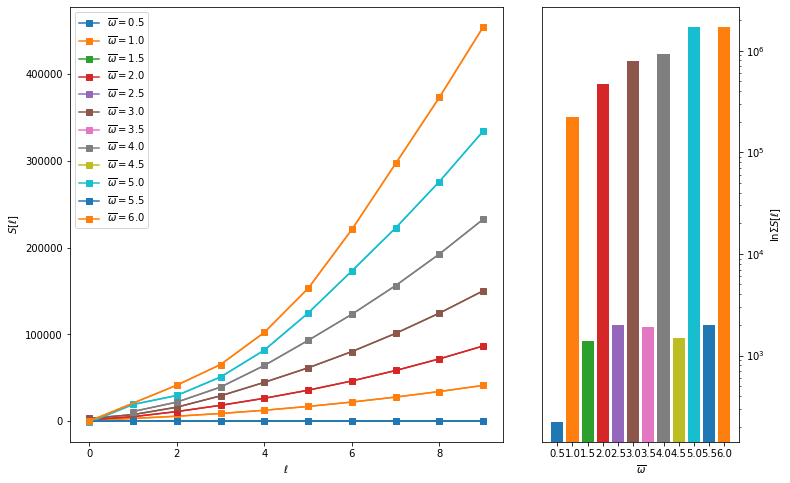

In [98]:
# Plot the results
svals = {}
totalvals = {}
# Read the data from the file. Dictionary key is the NN frequency, values are source terms S[l]
with open("NNEqualFrequencies.dat", "r") as f:
    lmax = 0
    tmp = []
    for line in f:
        # Read the line that contains the NN frequency value and the number of modes
        if "w =" in line:
            foo = line.strip().split(" = ")
            # Pick out the w value
            dkey = float(foo[1].split()[0])
            # Pick out the l value
            lmax = int(foo[-1])
        # Catch the sum of the source terms and store in separate dictionary
        elif "Sum" in line:
            tsum = line.strip().split(" = ")
            totalvals[dkey] = float(tsum[-1])
        # Otherwise, add the value to the list for that frequency
        else:
            if lmax <= 0:
                #print("Adding element to dictionary:")
                #print("svals[%s] = " % dkey)
                #print(tmp)
                svals[dkey] = tmp
                lmax = 0
                tmp = []
            else:
                bar = line.strip().split()
                tmp.append(float(bar[-1]))
                lmax -= 1

print(svals)
print(totalvals)

colours = ['C' + str(val) for val in range(10)] * int((len(svals) - 1)/10 + 1)
fig = plt.figure(figsize=(12,8))
gs = GridSpec(1,3,figure=fig)
ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0,-1])

# Plot the source terms S[l]
ii = 0
for key in sorted(svals.keys()):
    # Test for nan values caused by division by zero
    if np.any(np.isnan(svals.get(key))):
        temp = svals.get(key)
        xvals = np.arange(len(temp))
        nanvals = np.argwhere(np.isnan(temp))
        # Remove nan values and adjust arrays accordingly
        for indx in nanvals[0]:
            temp = np.delete(temp, [indx])
            xvals = np.delete(xvals, [indx])
        # Recalculate sum with nan values removed
        totalvals[key] = np.sum(temp)
        # Plot adjusted source terms
        ax1.plot(xvals, temp, marker='s', markerfacecolor=colours[ii], 
                 label=r'$\overline{\omega} = $' + str(key))
        ax1.plot(xvals, temp, color=colours[ii])
        
    else:
        ax1.plot(np.arange(len(svals.get(key))), svals.get(key)[:], marker='s', markerfacecolor=colours[ii], 
                 label=r'$\overline{\omega} = $' + str(key))
        ax1.plot(np.arange(len(svals.get(key))), svals.get(key)[:], color=colours[ii])
    ii += 1
    
ax1.set_xlabel(r'$\ell$')
#ax1.set_yscale('log')
ax1.set_ylabel(r'$S[\ell]$')
ax1.legend()

# Plot sum of source terms up to LMAX
sources = [str(key) for key in sorted(totalvals.keys())]

sums = [totalvals.get(key) for key in sorted(totalvals.keys())]
x_pos = np.arange(len(sources))
ax2.bar(x_pos, sums, color=colours[:len(sources)])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(sources)
ax2.set_yscale('log')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r'$\ln\Sigma S[\ell]$')
ax2.set_xlabel(r'$\overline{\omega}$')

fname = "NN_equalfreq_sourceterms.pdf"
plt.savefig("figures/" + fname, transparent=True, format="pdf")
print("Saved figure as", fname)
plt.show()


In [11]:
# Sources for two NN frequencies adding to an integer

def R1bar(i, w1, w2, l):
    n = (w1 + w2) / 2
    return 0.25 * Zmin(w1,w2,i,l) * (2 * n - omega(l)) / (2 * n)\
            - 0.25 * Zmin(i,w2,w1,l) * w1 * (omega(l) + w1) / (omega(l) ** 2 - w1 ** 2)\
            - 0.25 * Zmin(i,w1,w2,l) * w2 * (omega(l) + w2) / (omega(l) ** 2 - w2 ** 2)\
            - 0.25 * w1 * H(i,w1,w2,l) * (1 / (omega(l) - w2) + 1 / (2 * n))\
            - 0.25 * w2 * H(i,w2,w1,l) * (1 / (omega(l) - w1) + 1 / (2 * n))\
            - 0.25 * (omega(l) - 2 * n) * H(w1,i,w2,l) * (1 / (omega(l) - w1) +\
            1 / (omega(l) - w2)) + 0.5 * w1 * w2 * X(i,w1,w2,l) * (w2 / (omega(l) - w2) +\
            w1 / (omega(l) - w1) + 1) + 0.5 * (omega(l) - 2 * n) * w2 * X(w1,w2,i,l) *\
            (w2 / (omega(l) - w2) + 0.5 * omega(l) / n) + 0.5 * (omega(l) - 2 * n) * w1 *\
            X(w2,w1,i,l) * (w1 / (omega(l) - w1) + 0.5 * omega(l) / n)

def R2bar(i, w1, w2, l):
    n = (w1 + w2) / 2
    return 0.25 * Zmin(w1,w2,i,l) * ((omega(l) + 2 * n) / (2 * n))\
            - 0.25 * Zpl(i,w2,w1,l) * w1 * (omega(l) - w1) / (omega(l) ** 2 - w1 ** 2)\
            - 0.25 * Zpl(i,w1,w2,l) * w2 * (omega(l) - w2) / (omega(l) ** 2 - w2 ** 2)\
            + 0.25 * w1 * H(i,w1,w2,l) * (1 / (omega(l) + w2) - 0.5 / n)\
            + 0.25 * w2 * H(i,w2,w1,l) * ( 1 / (omega(l) + w1) - 0.5 / n)\
            - 0.25 * (omega(l) + 2 * n) * H(w1,i,w2,l) * (1 / (omega(l) + w1) + 1 / (omega(l) + w2))\
            - 0.5 * w1 * w2 * X(i,w1,w2,l) * (w2 / (omega(l) + w2) + w1 / (omega(l) + w1) - 1)\
            + 0.5 * (omega(l) + 2 * n) * w2 * X(w1,w2,i,l) * (w2 / (omega(l) + w2) + 0.5 * omega(l) / n)\
            + 0.5 * (omega(l) + 2 * n) * w1 * X(w2,w1,i,l) * (w1 / (omega(l) + w1) + 0.5 * omega(l) / n)
                                                                

In [16]:
# Give an input value of even integer 2n and sum over 
# possible values of w1 and w2

def atoi_Source(n, w1, Lmax):
    if (n % 1 != 0):
        print("ERROR: n must be an integer")
        return None
    else:
        outval = np.zeros((Lmax + 1,), dtype=np.double)
        for l in range(Lmax + 1):
            outval[l] = R2bar(n + l, w1, 2*n - w1, l)
            if (l - n >= 0):
                outval[l] += R1bar(l - n, w1, 2*n - w1, l)
            else:
                pass
            #print("S[%d] = %e" % (l, outval[l]))
        #print("Sum_0^%d = %e" % (Lmax, np.sum(outval)))
    return outval

atoi_Source(2,0.5,10)        

array([-0.20126986, -0.33403264, -0.70394808, -1.04315709, -1.45612142,
       -1.94469966, -2.50891419, -3.1486732 , -3.86390635, -4.65456758,
       -5.5206271 ])

In [18]:
# Examine different values of n by scanning over
# NN frequency values that add to 2n

# Try a step size for NN frequencies -- technically an infinite number of terms?
wstep = 0.1
n = 2
w1 = np.arange(wstep, 2*n, wstep)
with open("NNAddToInteger.dat", "w") as f:
    for val1 in w1:
        prog = 100 - (w1[-1] - val1) / (w1[-1] - w1[0]) * 100
        print('\rPercent complete: ' + '{:03.1f}'.format(prog) + '%', end='\r')
        result = atoi_Source(n, val1, 10)
        if result is None:
            pass
        else:
            f.write("Computing source terms for two NN modes with w1 = {:f}".format(val1) +
                        " and w2 = {:f}".format(2*n - val1) + " up to l = 10\n")
            for i in range(len(result)):
                f.write("S[" + str(i) + "] = {:e}\n".format(result[i]))
            f.write("Sum_0^{:d} = ".format(len(result)) + "{:e}\n".format(np.sum(result)))
    print("Wrote data to", f.name)

{(0.1, 3.9): [-0.06964965, -0.1089194, -0.229509, -0.3315306, -0.4569073, -0.6057042, -0.7777528, -0.9729528, -1.191249, -1.432608], (0.2, 3.8): [-0.1230008, -0.1953704, -0.4116403, -0.5986925, -0.8279072, -1.09969, -1.413828, -1.770176, -2.168652, -2.609205], (0.3, 3.7): [-0.1616293, -0.2606429, -0.549168, -0.8039526, -1.115387, -1.484357, -1.910686, -2.394226, -2.934886, -3.532611], (0.4, 3.6): [-0.1871665, -0.3062776, -0.6453669, -0.950696, -1.323107, -1.763993, -2.273268, -2.850804, -3.496517, -4.210353], (0.5, 3.5): [-0.2012699, -0.3340326, -0.7039481, -1.043157, -1.456121, -1.9447, -2.508914, -3.148673, -3.863906, -4.654568], (0.6, 3.4): [-0.2055948, -0.3458466, -0.7289869, -1.08633, -1.520679, -2.034262, -2.627211, -3.299477, -4.051006, -4.881764], (0.7, 3.3): [-0.2017703, -0.343799, -0.7248447, -1.085859, -1.524079, -2.041977, -2.63978, -3.317481, -4.075047, -4.912452], (0.8, 3.2): [-0.191376, -0.3300677, -0.6960862, -1.047918, -1.474505, -1.978432, -2.56, -3.219237, -3.956128,

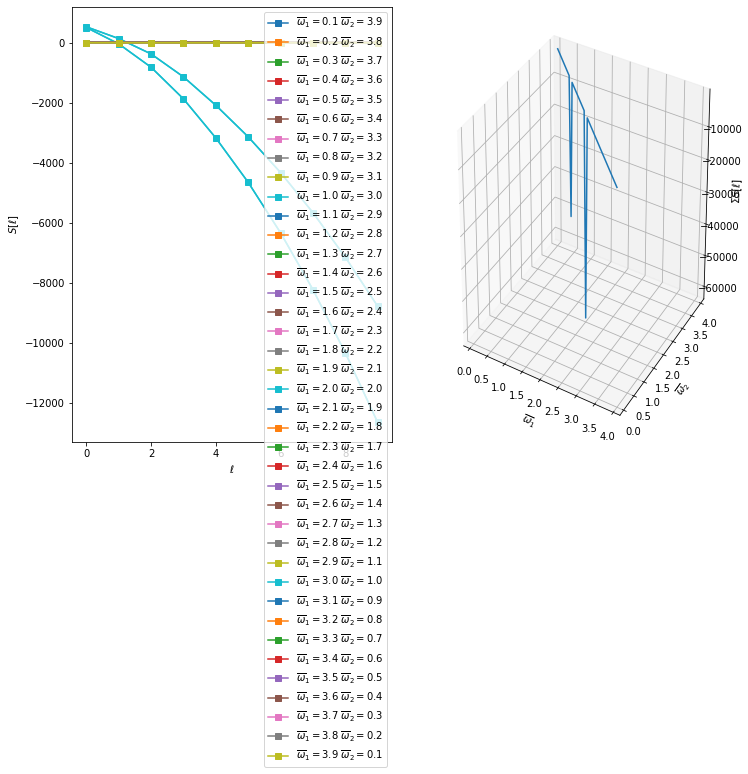

In [99]:
from mpl_toolkits.mplot3d import Axes3D

# Plot the results
svals = {}
totalvals = {}
# Read the data from the file. Dictionary key is the NN frequency, values are source terms S[l]
with open("NNAddToInteger.dat", "r") as f:
    lmax = 0
    tmp = []
    for line in f:
        # Read the line that contains the NN frequency value and the number of modes
        if "w1 =" in line:
            foo = line.strip().split(" = ")
            # Pick out the w1 and w2 values
            dkey = (float(foo[1].split()[0]), float(foo[2].split()[0]))
            # Pick out the l value
            lmax = int(foo[-1])
        # Catch the sum of the source terms and store in separate dictionary
        elif "Sum" in line:
            tsum = line.strip().split(" = ")
            totalvals[dkey] = float(tsum[-1])
        # Otherwise, add the value to the list for that frequency
        else:
            if lmax <= 0:
                svals[dkey] = tmp
                lmax = 0
                tmp = []
            else:
                # Lines containing separators can be skipped
                if "--" in line:
                    pass
                else:
                    bar = line.strip().split()
                    tmp.append(float(bar[-1]))
                    lmax -= 1
"""
print(svals.get((1.0,3.0)))
print(totalvals.get((1.0,3.0)))
print(svals.get((3.0,1.0)))
print(totalvals.get((3.0,1.0)))
print(svals.get((2.0,2.0)))
print(totalvals.get((2.0,2.0)))
"""

print(svals)
print(totalvals)
                    
colours = ['C' + str(val) for val in range(10)] * int((len(svals) - 1)/10 + 1)
fig = plt.figure(figsize=(12,8))
gs = GridSpec(1,4,figure=fig)
ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0,2:],projection='3d')

# Plot the source terms S[l]
ii = 0
for key in sorted(svals.keys()):
    # Test for nan values caused by division by zero
    if np.any(np.isnan(svals.get(key))):
        temp = svals.get(key)
        xvals = np.arange(len(temp))
        nanvals = np.argwhere(np.isnan(temp))
        # Remove nan values and adjust arrays accordingly
        for indx in nanvals[0]:
            temp = np.delete(temp, [indx])
            xvals = np.delete(xvals, [indx])
        # Recalculate sum with nan values removed
        totalvals[key] = np.sum(temp)
        # Plot adjusted source terms
        ax1.plot(xvals, temp, marker='s', markerfacecolor=colours[ii], 
                 label=r'$\overline{\omega}_1 = $' + str(key[0]) + r' $\overline{\omega}_2 = $' + str(key[1]))
        ax1.plot(xvals, temp, color=colours[ii])
        
    else:
        ax1.plot(np.arange(len(svals.get(key))), svals.get(key)[:], marker='s', markerfacecolor=colours[ii], 
                 label=r'$\overline{\omega}_1 = $' + str(key[0]) + r' $\overline{\omega}_2 = $' + str(key[1]))
        ax1.plot(np.arange(len(svals.get(key))), svals.get(key)[:], color=colours[ii])
    ii += 1
    
ax1.set_xlabel(r'$\ell$')
#ax1.set_yscale('log')
ax1.set_ylabel(r'$S[\ell]$')
ax1.legend()


# Plot sum of source terms up to LMAX in two axes
X = [key[0] for key in sorted(totalvals.keys())]
Y = [key[1] for key in sorted(totalvals.keys())]
Z = [totalvals.get(key) for key in sorted(totalvals.keys())]

ax2.plot(X, Y, Z)

ax2.set_xlabel(r'$\overline{\omega}_1$')
ax2.set_ylabel(r'$\overline{\omega}_2$')
ax2.set_zlabel(r'$\Sigma S[\ell]$')
ax2.zaxis.set_label_position("top")


fname = "NN_equalfreq_sourceterms.pdf"
plt.savefig("figures/" + fname, transparent=True, format="pdf")
print("Saved figure as", fname)
plt.show()
